In [1]:
import sys
import time
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt, matplotlib.image as mpimg
%matplotlib inline

labeled_images = pd.read_csv('train.csv', nrows = 20000)
images = labeled_images.iloc[:,1:]
labels = labeled_images.iloc[:,:1]

Using TensorFlow backend.


Epoch #10 ended and took 7.7 seconds
Epoch #20 ended and took 6.7 seconds
Finished trainingg


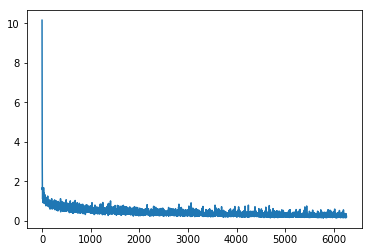

In [2]:
def getEqMat(labels):
    s = len(labels)
    Y = np.zeros((s, s), dtype = np.float64)
    for i in range(s):
        Y[i, :] = np.float64(labels == labels[i]).reshape(s,)
    return Y

def get_l2_model(layers, last_layer_activation_fn = None):
    x = tf.placeholder(tf.float64, [None, 784])
    y = tf.placeholder(tf.float64, [None, None])
    
    out = x
    for layer in layers[:-1]:
        out = tf.contrib.layers.fully_connected(out, layer, activation_fn = tf.nn.relu)
    out = tf.contrib.layers.fully_connected(out, layers[-1], activation_fn = last_layer_activation_fn)
    
    dist = tf.matmul(out, tf.transpose(out))
    norms = tf.reshape(tf.diag_part(dist), [-1, 1])
    dist = (-2*dist + norms) + tf.transpose(norms) + 1e-6
    
    m = tf.shape(x)[0]
    m = m*(m-1) / 2
    m = tf.cast(m, tf.float64)
    cost = tf.reduce_sum(tf.multiply(y, dist) + tf.divide(1-y, dist))
    cost = tf.divide(cost, m)
    
    return x, y, out, cost


m = 10000
iters = 20
minibatch_size = 32

t = 10000

X = images.values[:m, :] / 256.
Y = labels.values[:m, :]
    
X_test = images.values[m:m+t, :] / 256.
Y_test = labels.values[m:m+t, :]
    
x, y, out, cost = get_l2_model([50, 50, 10])
optimizer = tf.train.AdamOptimizer().minimize(cost)
init = tf.global_variables_initializer()

scores = np.array([])

with tf.Session() as sess:
    sess.run(init)
    start = time.time()
    for epoch in range(iters):
        
        order = np.random.permutation(m)

        for i in range(0, m, minibatch_size):
            indices = order[i : i + minibatch_size]
            Y_indices = getEqMat(Y[indices])
            _, J = sess.run([optimizer, cost], feed_dict = {x : X[indices,:], y : Y_indices})
            
            scores = np.append(scores, J)
        
        if epoch % 10 == 9:
            end = time.time()
            print('Epoch #{} ended and took {:.2} seconds'.format(epoch + 1, end - start))
            sys.stdout.flush()
            start = time.time()
    print('Finished trainingg')
    
    m_predictions, = sess.run([out], feed_dict = {x : X})
    t_predictions, = sess.run([out], feed_dict = {x : X_test})
plt.plot(scores)

In [3]:
p = np.array([m_predictions[np.where(Y == i)[0][0], :] for i in range(10)])

m_pred = np.array([])
for u in range(X.shape[0]):
    m_pred = np.append(m_pred, np.argmin(np.linalg.norm(p - m_predictions[u, :], axis = 1)))
m_pred = m_pred.reshape(-1, 1)

t_pred = np.array([])
for u in range(X_test.shape[0]):
    t_pred = np.append(t_pred, np.argmin(np.linalg.norm(p - t_predictions[u, :], axis = 1)))
t_pred = t_pred.reshape(-1, 1)

print('Train prediction rate = {}%'.format(100.0*np.sum(m_pred == Y) / len(Y)))
print('Test prediction rate = {}%'.format(100.0*np.sum(t_pred == Y_test) / len(Y_test)))

Train prediction rate = 98.84%
Test prediction rate = 94.22%
